In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


In [2]:
df = pd.read_parquet("green_tripdata_2022-09.parquet")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69031 entries, 0 to 69030
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               69031 non-null  int64         
 1   lpep_pickup_datetime   69031 non-null  datetime64[us]
 2   lpep_dropoff_datetime  69031 non-null  datetime64[us]
 3   store_and_fwd_flag     61968 non-null  object        
 4   RatecodeID             61968 non-null  float64       
 5   PULocationID           69031 non-null  int64         
 6   DOLocationID           69031 non-null  int64         
 7   passenger_count        61968 non-null  float64       
 8   trip_distance          69031 non-null  float64       
 9   fare_amount            69031 non-null  float64       
 10  extra                  69031 non-null  float64       
 11  mta_tax                69031 non-null  float64       
 12  tip_amount             69031 non-null  float64       
 13  t

In [3]:
df = df.drop(columns=['ehail_fee'], errors='ignore')


In [4]:
df['trip_duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60
df['weekday'] = df['lpep_dropoff_datetime'].dt.day_name()
df['hourofday'] = df['lpep_dropoff_datetime'].dt.hour


In [5]:
print(df['weekday'].value_counts())
print(df['hourofday'].value_counts())


weekday
Thursday     12712
Friday       12282
Wednesday    10159
Tuesday       9329
Monday        8698
Saturday      8561
Sunday        7290
Name: count, dtype: int64
hourofday
18    5490
17    5290
16    4800
15    4494
19    4358
14    4124
12    3917
11    3912
9     3825
10    3774
13    3748
20    3507
8     3039
21    2832
22    2448
7     2303
23    1999
0     1591
1     1005
6      929
2      593
3      406
4      326
5      321
Name: count, dtype: int64


In [6]:
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna("Unknown", inplace=True)


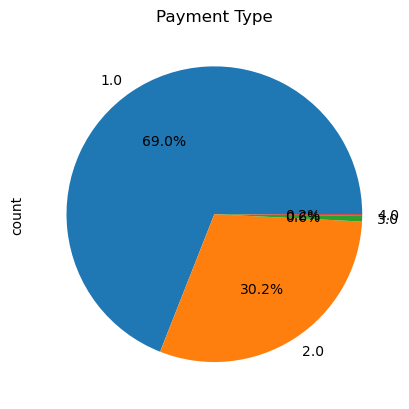

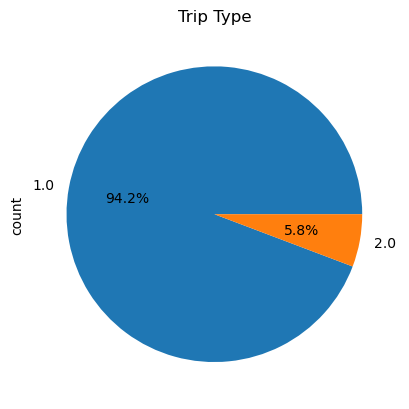

In [7]:
df['payment_type'].value_counts().plot.pie(autopct='%1.1f%%', title='Payment Type')
plt.show()

df['trip_type'].value_counts().plot.pie(autopct='%1.1f%%', title='Trip Type')
plt.show()


In [8]:
print(df.groupby('weekday')['total_amount'].mean())
print(df.groupby('payment_type')['total_amount'].mean())
print(df.groupby('weekday')['tip_amount'].mean())
print(df.groupby('payment_type')['tip_amount'].mean())


weekday
Friday       20.917702
Monday       20.388317
Saturday     21.836859
Sunday       22.181669
Thursday     20.639674
Tuesday      20.408449
Wednesday    19.857177
Name: total_amount, dtype: float64
payment_type
1.0    22.432055
2.0    17.610124
3.0     2.567546
4.0     4.543818
Name: total_amount, dtype: float64
weekday
Friday       2.107886
Monday       2.115389
Saturday     2.286607
Sunday       2.463915
Thursday     2.179994
Tuesday      2.177469
Wednesday    2.064520
Name: tip_amount, dtype: float64
payment_type
1.0    3.165754
2.0    0.000000
3.0   -0.015826
4.0    0.000000
Name: tip_amount, dtype: float64


In [9]:
from scipy.stats import f_oneway, chi2_contingency

# l) ANOVA for trip_type
f_oneway_result = f_oneway(*[group['total_amount'].dropna() for name, group in df.groupby('trip_type')])
print("ANOVA Trip Type:", f_oneway_result)

# m) ANOVA for weekday
f_oneway_result = f_oneway(*[group['total_amount'].dropna() for name, group in df.groupby('weekday')])
print("ANOVA Weekday:", f_oneway_result)

# n) Chi-square test
contingency_table = pd.crosstab(df['trip_type'], df['payment_type'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("Chi-Square between Trip Type & Payment Type:", chi2, p)


ANOVA Trip Type: F_onewayResult(statistic=7266.561752583365, pvalue=0.0)
ANOVA Weekday: F_onewayResult(statistic=15.378510217773783, pvalue=1.0512671025666996e-17)
Chi-Square between Trip Type & Payment Type: 201.43196727263916 2.0689430260329813e-43


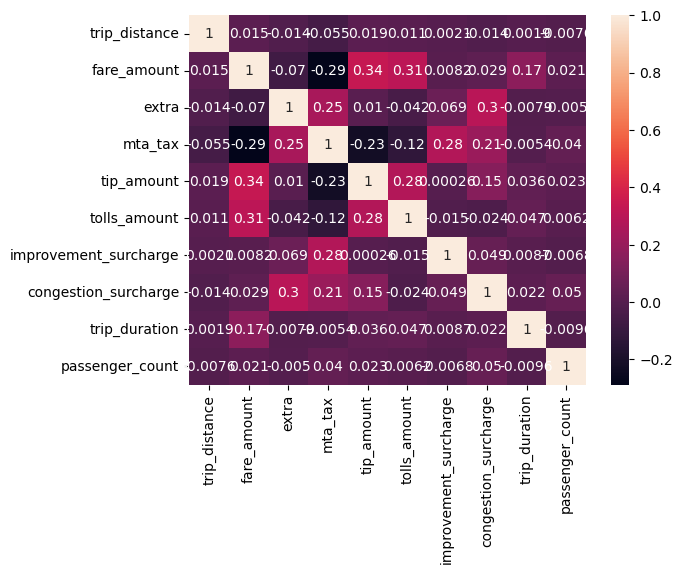

In [10]:
numeric_cols = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
                'improvement_surcharge', 'congestion_surcharge', 'trip_duration', 'passenger_count']
sns.heatmap(df[numeric_cols].corr(), annot=True)
plt.show()


In [11]:
df_encoded = pd.get_dummies(df, columns=[
    'store_and_fwd_flag', 'RatecodeID', 'payment_type', 'trip_type', 'weekday', 'hourofday'
])


In [12]:
features = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
            'improvement_surcharge', 'congestion_surcharge', 'trip_duration', 'passenger_count'] + \
           [col for col in df_encoded.columns if col.startswith(('store_and_fwd_flag_', 'RatecodeID_', 'payment_type_', 'trip_type_', 'weekday_', 'hourofday_'))]

X = df_encoded[features]
y = df_encoded['total_amount']

X = X.fillna(0)
y = y.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


R² Score: 0.9993242859608045
MSE: 0.2699232975753219


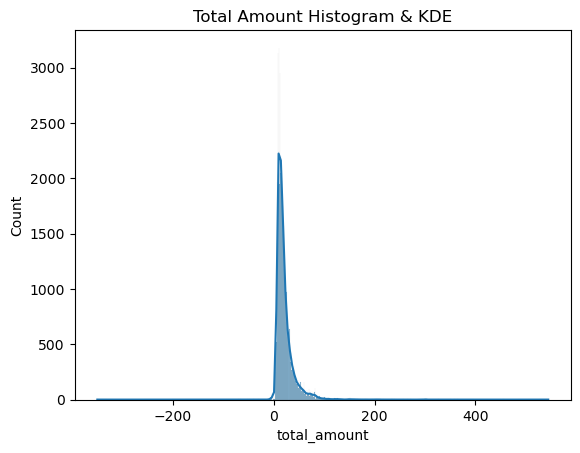

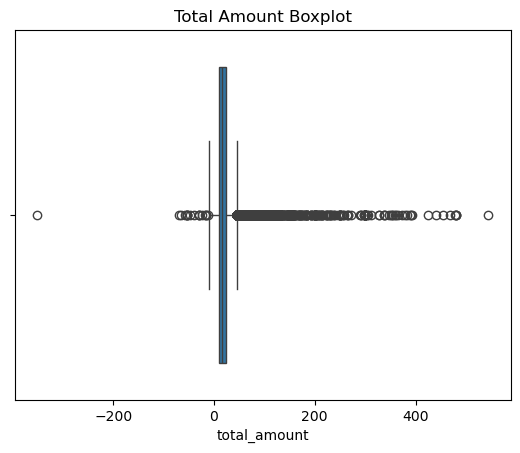

In [13]:
sns.histplot(df['total_amount'], kde=True)
plt.title("Total Amount Histogram & KDE")
plt.show()

sns.boxplot(x=df['total_amount'])
plt.title("Total Amount Boxplot")
plt.show()
